# Real estate price regression with XGBoost

Let's use XGBoost to figure out a pricing model for real estate.

In [95]:
import sys
sys.executable

'/Users/RSHAW/anaconda2/envs/py3/bin/python'

In [117]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import scipy.stats

from sklearn import linear_model
from sklearn import model_selection
from sklearn.metrics import explained_variance_score
from sklearn.preprocessing import OneHotEncoder

import xgboost

In [97]:
# load the csv file into a pandas dataframe
dat = pd.read_csv('kc_house_data.csv')

## Inspect the data

In [98]:
dat.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [99]:
dat.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.161300e+04,2.161300e+04,21613.000000,21613.000000,21613.000000,2.161300e+04,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000
mean,4.580302e+09,5.400881e+05,3.370842,2.114757,2079.899736,1.510697e+04,1.494309,0.007542,0.234303,3.409430,7.656873,1788.390691,291.509045,1971.005136,84.402258,98077.939805,47.560053,-122.213896,1986.552492,12768.455652
std,2.876566e+09,3.671272e+05,0.930062,0.770163,918.440897,4.142051e+04,0.539989,0.086517,0.766318,0.650743,1.175459,828.090978,442.575043,29.373411,401.679240,53.505026,0.138564,0.140828,685.391304,27304.179631
min,1.000102e+06,7.500000e+04,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,2.123049e+09,3.219500e+05,3.000000,1.750000,1427.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,0.000000,98033.000000,47.471000,-122.328000,1490.000000,5100.000000
50%,3.904930e+09,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,0.000000,98065.000000,47.571800,-122.230000,1840.000000,7620.000000
75%,7.308900e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.068800e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,560.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


In [100]:
# any NaNs?
dat.isnull().any()

id               False
date             False
price            False
bedrooms         False
bathrooms        False
sqft_living      False
sqft_lot         False
floors           False
waterfront       False
view             False
condition        False
grade            False
sqft_above       False
sqft_basement    False
yr_built         False
yr_renovated     False
zipcode          False
lat              False
long             False
sqft_living15    False
sqft_lot15       False
dtype: bool

Cool, no NaNs

## Price correlations with each feature

In [101]:
features = dat.loc[:, 'bedrooms':]

In [102]:
# we will populate a dictionary with keys according to feature column
correlations = {}
column_names = features.columns
price = dat['price']
for c in column_names:
    feature = dat[c]
    correlations[c] = scipy.stats.pearsonr(feature, price)[0]
#     correlations[c+' spearman'] = scipy.stats.spearmanr(feature, price)[0]
correlations = sorted([(correlations[x], x) for x in correlations.keys()], reverse=True)
correlations

[(0.7020350546118, 'sqft_living'),
 (0.6674342560202371, 'grade'),
 (0.6055672983560783, 'sqft_above'),
 (0.585378903579568, 'sqft_living15'),
 (0.5251375054139619, 'bathrooms'),
 (0.3972934882945043, 'view'),
 (0.32381602071198395, 'sqft_basement'),
 (0.3083495981456383, 'bedrooms'),
 (0.3070034799952186, 'lat'),
 (0.2663694340306021, 'waterfront'),
 (0.2567938875507184, 'floors'),
 (0.12643379344089295, 'yr_renovated'),
 (0.08966086058710011, 'sqft_lot'),
 (0.08244715251948598, 'sqft_lot15'),
 (0.054011531494792715, 'yr_built'),
 (0.036361789128997554, 'condition'),
 (0.021626241039305872, 'long'),
 (-0.05320285429832561, 'zipcode')]

#### Sidenote: zipcode
we should turn zipcode from a numeric quantity into a one-hot categorization.

In [103]:
dat.zipcode.unique()

array([98178, 98125, 98028, 98136, 98074, 98053, 98003, 98198, 98146,
       98038, 98007, 98115, 98107, 98126, 98019, 98103, 98002, 98133,
       98040, 98092, 98030, 98119, 98112, 98052, 98027, 98117, 98058,
       98001, 98056, 98166, 98023, 98070, 98148, 98105, 98042, 98008,
       98059, 98122, 98144, 98004, 98005, 98034, 98075, 98116, 98010,
       98118, 98199, 98032, 98045, 98102, 98077, 98108, 98168, 98177,
       98065, 98029, 98006, 98109, 98022, 98033, 98155, 98024, 98011,
       98031, 98106, 98072, 98188, 98014, 98055, 98039])

In [124]:
enc = OneHotEncoder(categorical_features='zipcode')
enc.fit(dat.zipcode)

ValueError: Expected 2D array, got 1D array instead:
array=[98178. 98125. 98028. ... 98144. 98027. 98144.].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

### Visualize the top correlations
Let's plot feature vs. price for the top n correlations

In [104]:
top_features = [correlations[i][1] for i in range(4)]
top_features

['sqft_living', 'grade', 'sqft_above', 'sqft_living15']

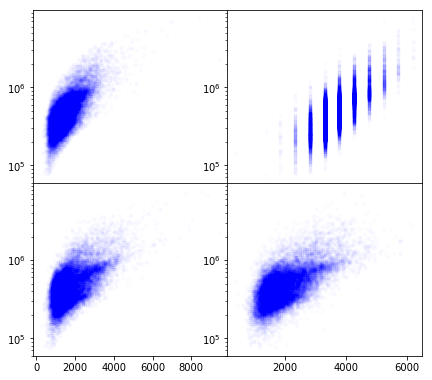

In [105]:
fig = plt.figure(1, figsize=(6, 6))
axes = {}
axes[top_features[0]] = fig.add_axes([0.05, 0.5, 0.45, 0.4])
axes[top_features[1]] = fig.add_axes([0.50, 0.5, 0.45, 0.4])
axes[top_features[2]] = fig.add_axes([0.05, 0.1, 0.45, 0.4])
axes[top_features[3]] = fig.add_axes([0.50, 0.1, 0.45, 0.4])
for feature in top_features:
    ax = axes[feature]
    ax.set_yscale("log", nonposy='clip')
    ax.plot(dat[feature].tolist(), dat['price'].tolist(), 'b.', alpha=0.01)
plt.show(fig)

## Linear Regression

In [106]:
top_features = [correlations[i][1] for i in range(11)]
top_features

['sqft_living',
 'grade',
 'sqft_above',
 'sqft_living15',
 'bathrooms',
 'view',
 'sqft_basement',
 'bedrooms',
 'lat',
 'waterfront',
 'floors']

In [107]:
target = dat.price
# features = dat[top_features]
features = dat[['sqft_living','grade', 'sqft_above', 'sqft_living15','bathrooms','view','sqft_basement','lat','waterfront','yr_built','bedrooms']]

features_train, features_test, target_train, target_test =\
model_selection.train_test_split(features.values, target.values, test_size=0.2)

regr = linear_model.LinearRegression()
regr.fit(features_train, target_train)
regr.score(features_test, target_test)

predictions = regr.predict(features_test)

In [108]:
def rmse(predictions, target):
    return np.sqrt(np.mean((predictions-target)**2))

In [109]:
print(regr.score(features_test, target_test))
print(rmse(predictions, target_test))
print(np.mean(target_test))

0.6939318237758291
186452.7705267373
528979.8237335184


## XGBoost regression
We can do better.

In [110]:
xgb = xgboost.XGBRegressor(n_estimators=100, learning_rate=0.08,
                           gamma=0, subsample=0.75, 
                           colsample_bytree=1, max_depth=7)

In [111]:
target = dat.price
# features = dat[top_features]
features = dat[['sqft_living','grade', 'sqft_above', 'sqft_living15','bathrooms','view','sqft_basement','lat','waterfront','yr_built','bedrooms']]

features_train, features_test, target_train, target_test =\
model_selection.train_test_split(features.values, target.values, test_size=0.2)

xgb.fit(features_train, target_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.08, max_delta_step=0,
       max_depth=7, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.75)

In [112]:
predictions = xgb.predict(features_test)

In [113]:
explained_variance_score(predictions, target_test)

0.829298732431516

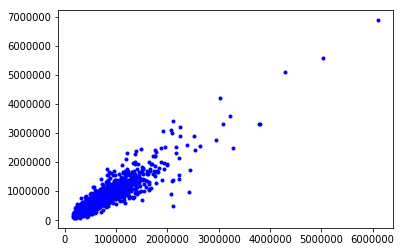

In [127]:
plt.plot(predictions, target_test, 'b.')
plt.show()

In [115]:
print(rmse(predictions, target_test))
print(np.mean(target_test))

140078.24060880629
541002.625260236
